In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import random
import scipy
from scipy import interpolate
from numba import njit, int64, float64
from numba.experimental import jitclass

### Output, Consumption and Debt

A small open economy is endowed with an exogenous stochastically fluctuating potential output
stream $ \{y_t\} $.

Potential output is realized only in periods in which the government honors its sovereign debt.

The output good can be traded or consumed.

The sequence $ \{y_t\} $ is described by a Markov process with stochastic density kernel
$ p(y, y') $.

* In particular we discretize an AR(1) process for $ln(y_s)$ using Tauchen Method.

Households within the country are identical and rank stochastic consumption streams according to


<a id='equation-utility'></a>
$$
\mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t) \tag{13.1}
$$

Here

- $ 0 < \beta < 1 $ is a time discount factor  
- $ u $ is an increasing and strictly concave utility function  


Consumption sequences enjoyed by households are affected by the government’s decision to borrow or
lend internationally.

The government is benevolent in the sense that its aim is to maximize [(13.1)](#equation-utility).

The government is the only domestic actor with access to foreign credit.

Because household are averse to consumption fluctuations, the government will try to smooth
consumption by borrowing from (and lending to) foreign creditors.

### Asset Markets

The only credit instrument available to the government is a one-period bond traded in international credit markets.

The bond market has the following features

- The bond matures in one period and is not state contingent.  
- A purchase of a bond with face value $ B' $ is a claim to $ B' $ units of the
  consumption good next period.  
- To purchase $ B' $  next period costs $ q B' $ now, or, what is equivalent.  
- For selling $ -B' $ units of next period goods the seller earns $ - q B' $ of today’s
  goods.  
  - If $ B' < 0 $, then $ -q B' $ units of the good are received in the current period,
    for a promise to repay $ -B' $ units next period.  
  - There is an equilibrium  price function $ q(B', y) $ that makes $ q $ depend on both
    $ B' $ and $ y $.  


Earnings on the government portfolio are distributed (or, if negative, taxed) lump sum to
households.

When the government is not excluded from financial markets, the one-period national budget
constraint is


<a id='equation-resource'></a>
$$
c = y + B - q(B', y) B' \tag{13.2}
$$

Here and below, a prime denotes a next period value or a claim maturing next period.

To rule out Ponzi schemes, we also require that $ B \geq -Z $ in every period.

- $ Z $ is chosen to be sufficiently large that the constraint never binds in equilibrium.  

### Financial Markets

Foreign creditors:

- Are risk neutral.
- Know the domestic output stochastic process $ \{y_t\} $ and observe
  $ y_t, y_{t-1}, \ldots, $ at time $ t $.
- Can borrow or lend without limit in an international credit market at a constant international
  interest rate $ r $.
- Receive full payment if the government chooses to pay. 
- Receive zero if the government defaults on its one-period debt due. 


When a government is expected to default next period with probability $ \delta $, the expected
value of a promise to pay one unit of consumption next period is $ 1 - \delta $.

Therefore, the discounted expected value of a promise to pay $ B $ next period is


<a id='equation-bondprice'></a>
$$
q = \frac{1 - \delta}{1 + r} \tag{13.3}
$$

Next we turn to how the government in effect chooses the default probability $ \delta $.

### Government’s Decisions

At each point in time $ t $, the government chooses between

1. defaulting  
1. meeting its current obligations and purchasing or selling an optimal quantity of  one-period
  sovereign debt  


Defaulting means declining to repay all of its current obligations.

If the government defaults in the current period, then consumption equals current output.

But a sovereign default has two consequences:

1. Output immediately falls from $ y $ to $ h(y) $, where $ 0 \leq h(y) \leq y $.  
  - It returns to $ y $ only after the country regains access to international credit
    markets.  
1. The country loses access to foreign credit markets.  

### Reentering International Credit Market

While in a state of default, the economy regains access to foreign credit in each subsequent
period with probability $ \theta $.

### Definition of Equilibrium

An *equilibrium* is

- a pricing function $ q(B',y) $,  
- a triple of value functions $ (v_c(B, y), v_d(y), v(B,y)) $,  
- a decision rule telling the government when to default and when to pay as a function of the state
  $ (B, y) $, and  
- an asset accumulation rule that, conditional on choosing not to default, maps $ (B,y) $ into
  $ B' $  


such that

- The three Bellman equations for $ (v_c(B, y), v_d(y), v(B,y)) $ are satisfied  
- Given the price function $ q(B',y) $, the default decision rule and the asset accumulation
  decision rule attain the optimal value function  $ v(B,y) $, and  
- The price function $ q(B',y) $ satisfies equation [(13.3)](#equation-bondprice)  

### Computation:

Here is a more detailed description of the algorithm this code follows:

1. Guess a pair of non-default $v_c(b, y)$ and default value functions $v_d(y)$ and .

2. Using these functions, calculate the value function $v = \max\{v_c(b, y), v_d(y)\}$, the corresponding default probabilities $d(B, y)$ and the price function $q(b^{\prime}, y)$.

At each pair;

3. update the value of defaulting $v^{\prime}_d(y)$:

$$v^{\prime}_d(y)=u(h(y))+\beta \int\left\{\theta v\left(0, y^{\prime}\right)+(1-\theta) v_d\left(y^{\prime}\right)\right\} p\left(y, y^{\prime}\right) d y^{\prime} $$

4. update the value of remaining $v^{\prime}_c(b, y)$.

$$ v_c(B, y)=\max _{B^{\prime} \geq-Z}\left\{u\left(y-q\left(B^{\prime}, y\right) B^{\prime}+B\right)+\beta \int v\left(B^{\prime}, y^{\prime}\right) p\left(y, y^{\prime}\right) d y^{\prime}\right\} $$

5. Check for convergence. If converged, stop – if not, go to step 2.


### Parameters: ###


$B_{min}= -0.45, B_{max} = 0.45, B_{size} = 500, y_{size} = 51, \beta= 0.953, \gamma = 2, r = 0.017, \rho=0.945, \sigma = 3, \eta = 0.025, \theta = 0.282, y^{hat} = 0.9690$


In [2]:
class Arellano_Economy:

    def __init__(self, B_grid_size = 100, B_grid_min = -0.45, B_grid_max = 0.45, y_grid_size = 51, β = 0.953, 
                    γ = 2.0, r = 0.017, ρ = 0.945, σ = 3, η = 0.025, θ = 0.3, def_y_param = 0.98):

        ### Unload parameters:
        self.β, self.γ, self.r = β, γ, r
        self.ρ, self.η, self.θ = ρ, η, θ

        self.B_grid_max = B_grid_max
        self.B_grid_min = B_grid_min

        self.y_grid_size = y_grid_size
        self.B_grid_size = B_grid_size
        self.B_grid = np.linspace(B_grid_min, B_grid_max, B_grid_size)

        ### Output is distributed as an AR(1) in logs:
        # Probability matrix and states:
        # note that element (i,j) of P represents the transition probability
        # of going to state "j" given that we are in state "i".

        #markov = qe.markov.approximation.rouwenhorst( n = y_grid_size, ybar = 0, sigma = σ, rho = ρ)
        #self.P = markov.P   
        #self.y_grid = np.exp(markov.state_values)
        
        mc = qe.markov.tauchen(ρ, η, 0, 3, y_grid_size)
        self.y_grid, self.P = np.exp(mc.state_values), mc.P 

        """ Index at which B_grid is (close to) zero:
        numpy.searchsorted(a, v, side='left', sorter=None)
        Find indices where elements should be inserted to maintain order.
        Find the indices into a sorted array <a> such that, if the corresponding elements
        in <v> were inserted before the indices, the order of <a> would be preserved.
        
        For example: np.searchsorted([1,2,3,4,5], 3)
        >> 2        
         """

        self.B0_idx = np.searchsorted(self.B_grid, 1e-10)

        ### Output recieved while in default, with the same shape as y_grid:

        self.def_y = np.minimum(def_y_param * np.mean(self.y_grid), self.y_grid)

        ### Define parameters and arrays:

    def params(self):
        return self.β, self.γ, self.r, self.ρ, self.η, self.θ

    def arrays(self):
        return self.P, self.y_grid, self.B_grid, self.def_y, self.B0_idx      

In [3]:
### Defining the ulility function:
@njit
def u(c, γ):
    return c**(1-γ)/(1-γ)

In [4]:
### Updating prices as a function of v_c(b, y) and v_d(y):

@njit
def compute_q(v_c, v_d, q, params, arrays):
    """
    Compute the bond price function q(b', y) at each (b', y) pair.
    This function writes to the array q that is passed in as an argument!
    """
    
    ### Unpack parameters:

    β, γ, r, ρ, η, θ = params
    P, y_grid, B_grid, y_def, B0_idx = arrays 

    for B_idx in range(len(B_grid)):
        for y_idx in range(len(y_grid)):
            """ 
            We want to update the price schedule for debt.

            Assume that the government has repayed its debt today, and
            is now looking to issue new debt B_grid[B_idx]. We know that 
            tomorrow the goverment might default in same states, given 
            the initial level of debt B_grid[B_idx].

            default_states: Using the old repayment value function, look 
            when will the country optimally choose to repay and when to 
            default.

            delta: Using this default decision we can compute the implicit
            probabilities of default. Note that to compute the transition
            probabilities we need to keep track of the endowment today.

            q(B_idx, y_idx): Given and income of y_idx and a debt issuance of
            B_grid[B_idx] we can compute the updated price.            
            """

            default_states = 1.0 * (v_c[B_idx, :] < v_d)
            delta = np.dot(default_states, P[y_idx, :])
            q[B_idx, y_idx] = (1 - delta) / (1 + r)

In [5]:
### Introducing Bellman operators that update value functions:

@njit
def T_d(y_idx, v_c, v_d, params, arrays):
    """
    The RHS of the Bellman equation when income is at index y_idx and
    the country has chosen to default.  Returns an update of v_d.

    Given that the goverment chose to default over its debt, we know
    that the continuation value if the goverment is allowed to back to
    the financial markets is given by max{v_c[B0_idx, :], v_d} since 
    the goverment re-enters with zero debt.    
    """

    ### Unpack parameters:

    β, γ, r, ρ, η, θ = params 
    P, y_grid, B_grid, def_y, B0_idx = arrays

    current_utility = u(def_y[y_idx], γ)
    v = np.maximum(v_c[B0_idx, :], v_d)
    cont_value = np.sum((θ * v + (1 - θ) * v_d) * P[y_idx, :])

    return current_utility + β * cont_value

In [6]:
@njit
def T_c(B_idx, y_idx, v_c, v_d, q, params, arrays):
    """
    The RHS of the Bellman equation when the country is not in a
    defaulted state on their debt (We are assuming that the country
    repays all the old debt).  Returns a value that corresponds to
    v_c[B_idx, y_idx], as well as the optimal level of bond sales B'.

    B = B_grid[B_idx]: The debt that this government need to pay
    before thinking about what is the optimal debt.
    """

    ### Unpack parameters:

    β, γ, r, ρ, η, θ = params 
    P, y_grid, B_grid, def_y, B0_idx = arrays
    B = B_grid[B_idx]
    y = y_grid[y_idx]

    """
    Enumerate() method adds a counter to an iterable and returns it in a form
    of enumerating object. This enumerated object can then be used directly 
    for loops or converted into a list of tuples using the list() method.
    """

    # Given a state and a level for wealth:

    current_max = -1e10

    ### This will compute the value of repayment, even if repayment is not
    # optimal. It won't update if repayment is not feasible. ie: c<0.
    
    """
    v: The continuation value given the choice of debt.
    val: The expected discounted value of Choosing debt B_idx
    while income today is y_grid[y_idx].

    Bp_star_idx: The best choice for bonds today.

    Remark: Note that it might be the case that the debt today is so high
    that default is always a better choice than paying the debt. Even if 
    this is case, can it happen that for every combination of debt tomorrow
    consumption is negative? If so, after updating the continuation value 
    nothing will change for this given specification of debt and income. If 
    this is not the case, there exist a level such that positive consumption 
    then this process will update the whole v_c(b,y).

    since b_min = 0.45, by construction we will never face that problem.
    """

    for Bp_idx, Bp in enumerate(B_grid):
        c = y + B - q[Bp_idx, y_idx] * Bp
        if c > 0:
            v = np.maximum(v_c[Bp_idx, :], v_d)
            val = u(c, γ) + β * np.sum(v * P[y_idx, :])
            if val > current_max:
                current_max = val
                Bp_star_idx = Bp_idx
    return current_max, Bp_star_idx

In [7]:
### Update prices, v_d, v_c. 
# Note that we are updating prices before we update v_d and v_c.
# output, v^{\prime}(b,y) v^{\prime}_d.

@njit(parallel=True)
def update_values_and_prices(v_c, v_d, B_star, q, params, arrays):

    # Unpack 
    β, γ, r, ρ, η, θ = params 
    P, y_grid, B_grid, def_y, B0_idx = arrays
    y_grid_size = len(y_grid)
    B_grid_size = len(B_grid)

    # Compute bond prices and write them to q
    compute_q(v_c, v_d, q, params, arrays)

    # Allocate memory
    new_v_c = np.empty_like(v_c)
    new_v_d = np.empty_like(v_d)

    # Calculate and return new guesses for v_c and v_d
    
    for y_idx in range(y_grid_size):
        ### Update the value of default:
        new_v_d[y_idx] = T_d(y_idx, v_c, v_d, params, arrays)
        ### Update the value of repayment and optimal debt:
        for B_idx in range(B_grid_size):
            new_v_c[B_idx, y_idx], Bp_idx = T_c(B_idx, y_idx, v_c, v_d, q, params, arrays)
            B_star[B_idx, y_idx] = Bp_idx

    return new_v_c, new_v_d

In [8]:
def solve(model, tol=1e-8, max_iter=10_000):
    """
    Given an instance of Arellano_Economy, this function computes the optimal
    policy and value functions.
    """
    # Unpack
    params = model.params()
    arrays = model.arrays()
    y_grid_size, B_grid_size = model.y_grid_size, model.B_grid_size 

    # Initial conditions for v_c and v_d
    v_c = np.zeros((B_grid_size, y_grid_size))
    v_d = np.zeros(y_grid_size)

    # Allocate memory
    q = np.empty_like(v_c)
    B_star = np.empty_like(v_c, dtype=int)

    current_iter = 0
    dist = np.inf
    
    while (current_iter < max_iter) and (dist > tol):

        if current_iter % 100 == 0:
            print(f"Entering iteration {current_iter}.")

        new_v_c, new_v_d = update_values_and_prices(v_c, v_d, B_star, q, params, arrays)
        
        # Check tolerance and update

        dist = np.max(np.abs(new_v_c - v_c)) + np.max(np.abs(new_v_d - v_d))
        v_c = new_v_c
        v_d = new_v_d
        current_iter += 1

    print(f"Terminating at iteration {current_iter}.")
    return v_c, v_d, q, B_star 

In [9]:
def simulate(model, T, v_c, v_d, q, B_star, y_idx=None, B_idx=None):
    """
    Simulates the Arellano 2008 model of sovereign debt

    Here `model` is an instance of `Arellano_Economy` and `T` is the length of
    the simulation.  Endogenous objects `v_c`, `v_d`, `q` and `B_star` are
    assumed to come from a solution to `model`.

    y_idx: Where you want to start in terms of output.
    B_idx: where you want to start in terms of debt.

    By default both values are the mean of endowments and a 0 stock of bonds.

    """
    # Unpack elements of the model:
    B0_idx = model.B0_idx
    y_grid = model.y_grid
    B_grid, y_grid, P = model.B_grid, model.y_grid, model.P

    # Set initial conditions to middle of grids:
    if y_idx == None:
        y_idx = np.searchsorted(y_grid, y_grid.mean())
    if B_idx == None:
        B_idx = B0_idx
    in_default = False

    # Create Markov chain and simulate income process
    mc = qe.MarkovChain(P, y_grid)
    y_sim_indices = mc.simulate_indices(T+1, init=y_idx)

    # Allocate memory for outputs
    y_sim = np.empty(T)
    y_a_sim = np.empty(T)
    B_sim = np.empty(T)
    q_sim = np.empty(T)
    d_sim = np.empty(T, dtype=int)

    # Perform simulation:
    t = 0
    while t < T:

        ### Store the value of y_t and B_t:
        # Initial endowment equal to the specified above.
        # Initial debt equal to the specified above.
        # B_sim is the amount of outstading debt at t.

        y_sim[t] = y_grid[y_idx]
        B_sim[t] = B_grid[B_idx]

        ### If the goverment chooses to default:
        # Create an auxiliarly variable called in_default.
        # If in_default = True then the country is still in 
        # default.

        if v_c[B_idx, y_idx] < v_d[y_idx] or in_default:

            # Output decreases in that period.
            y_a_sim[t] = model.def_y[y_idx]
            # Default indicator turns on.
            d_sim[t] = 1
            # If there is debt tomorrow it will be zero, because
            # the country is re-entering the financial markets.
            Bp_idx = B0_idx
            # Re-enter financial markets next period with prob θ
            in_default = False if np.random.rand() < model.θ else True

        else:
            
            y_a_sim[t] = y_sim[t]
            d_sim[t] = 0
            Bp_idx = B_star[B_idx, y_idx]

        q_sim[t] = q[Bp_idx, y_idx]
        t += 1
        y_idx = y_sim_indices[t]
        B_idx = Bp_idx

        """ 
        Update time and indices:

        We follow the markov chain previously simulated.
        We chose the level of debt chosen in the previuous perdiod.

        But what would happen if the goverment defaults? 

        If the goverment defaults on this period, then automatically the debt
        chosen for tomorrow will become zero until the country is allowed to
        re-enter the financial markets.

        If the contry is allowed to enter the financial markets in the next
        period, the country start with zero debt and an endowment that follows
        the markov chain that was previously generated.

        Remark: Note that defaulting implies that the country automatically 
        looses output and it's forced to consume h(y). We are not allowing
        by constructing any sort of saving after default. 
        """
        

    return y_sim, y_a_sim, B_sim, q_sim, d_sim

### Solving the Model for Arrellano (2008): ###

In [10]:
# Create an instance of the class

Ar_Econ = Arellano_Economy()

# Solve the calibrated model:

Solution = solve(Ar_Econ)
v_c, v_d, q, B_star = Solution

Entering iteration 0.


C:\Users\belmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numba\core\typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "..\..\..\..\AppData\Local\Temp\ipykernel_14208\626543806.py", line 5:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


Entering iteration 100.
Entering iteration 200.
Entering iteration 300.
Terminating at iteration 399.


### Simulated Economy ###

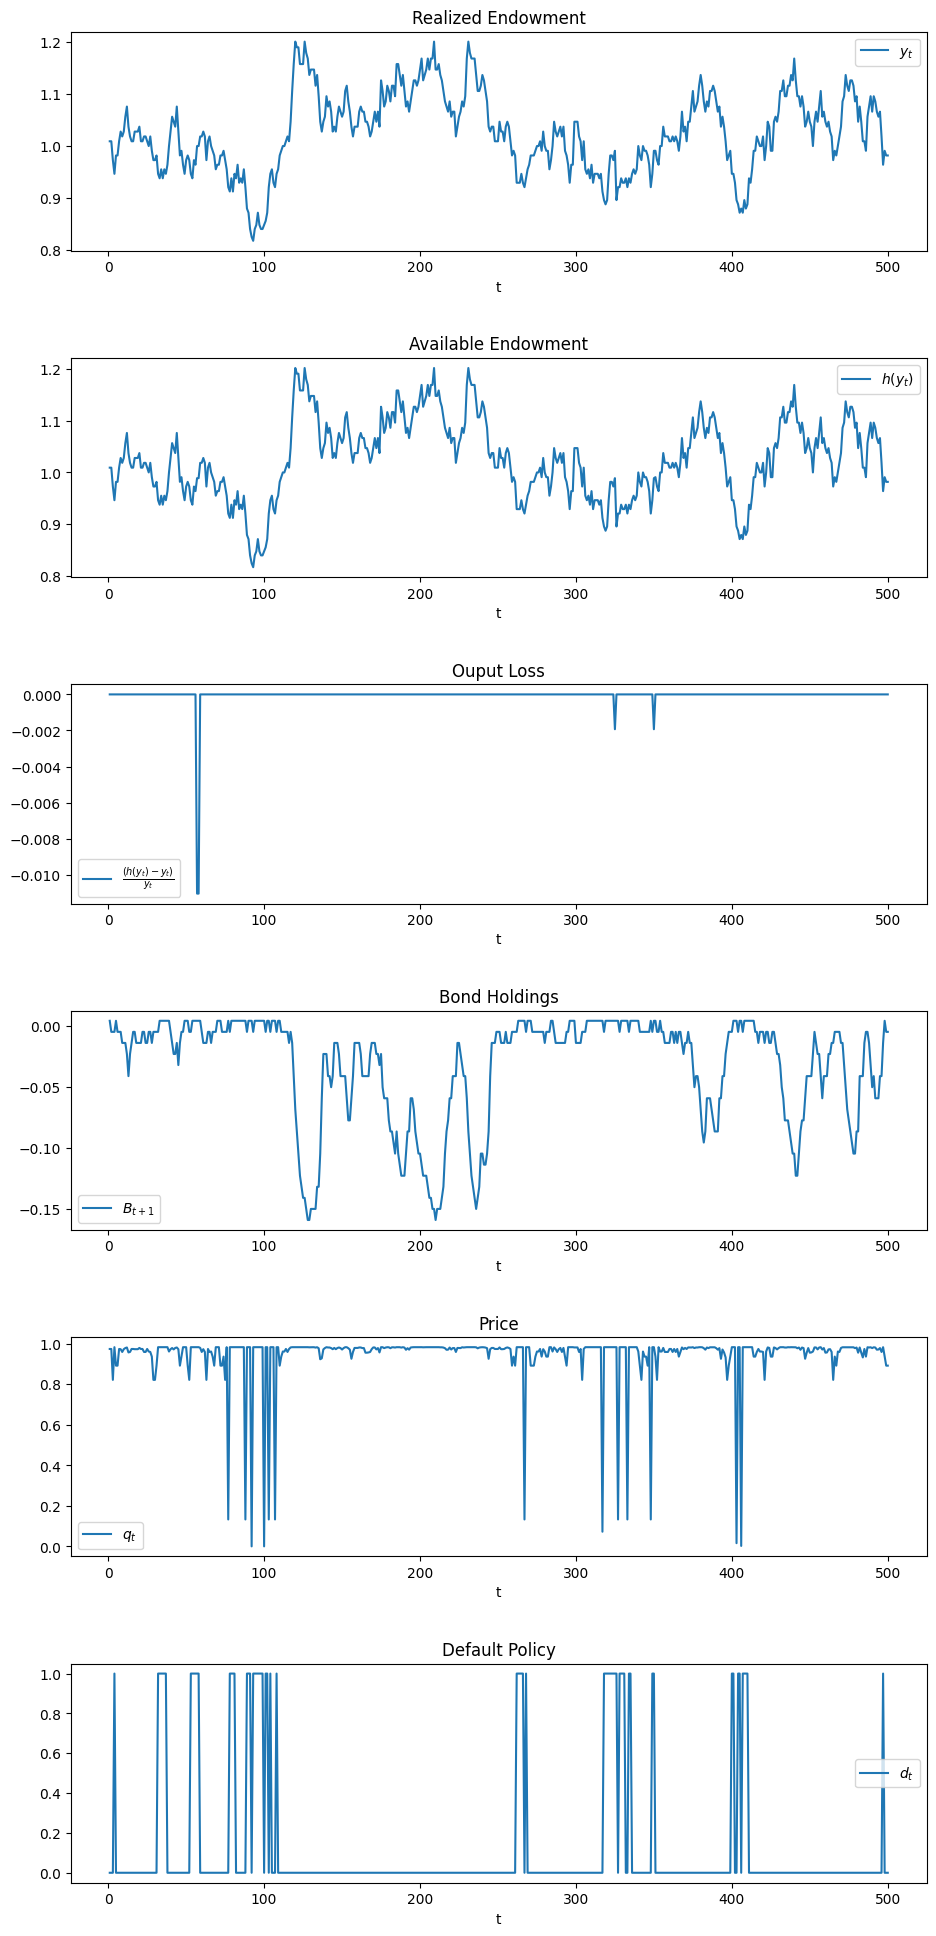

In [11]:
### Simulations:
T = 500
y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ar_Econ, T, v_c, v_d, q, B_star)

T = 500
fig, ax = plt.subplots(7, figsize=(10,20))

for i in range(1):
    #Plot endowments time series:
    y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ar_Econ, T, v_c, v_d, q, B_star)
    ax[0].plot(np.linspace(1, T, T), y_sim, label = r'$y_{t}$')
    ax[0].legend()
    ax[0].set_title('Realized Endowment')
    ax[0].set(xlabel='t')
    # Net income time series (In default ouput decreases):
    ax[1].plot(np.linspace(1, T, T), y_a_sim, label = r'$h(y_{t})$')
    ax[1].legend()
    ax[1].set_title('Available Endowment')
    ax[1].set(xlabel='t')
    # Output loss:
    ax[2].plot(np.linspace(1, T, T), (y_a_sim - y_sim)/ y_sim, label = r'$\frac{(h(y_{t}) - y_{t})}{y_{t}}$')
    ax[2].legend()
    ax[2].set_title('Ouput Loss')
    ax[2].set(xlabel='t')
    # Bond Holding Simulation:
    ax[3].plot(np.linspace(1, T, T), B_sim, label = r'$B_{t+1}$')
    ax[3].legend()
    ax[3].set_title('Bond Holdings')
    ax[3].set(xlabel='t')
    #Price Simulation:
    ax[4].plot(np.linspace(1, T, T), q_sim, label = r'$q_{t}$')
    ax[4].legend()
    ax[4].set_title('Price')
    ax[4].set(xlabel='t')
    # Default Simulation:
    ax[5].plot(np.linspace(1, T, T), d_sim, label = r'$d_{t}$')
    ax[5].legend()
    ax[5].set_title('Default Policy')
    ax[5].set(xlabel='t')
    # Consumption:
    ax[6].plot(np.linspace(1, T-1, T-1), c_sim, label = r'$c_{t}$')
    ax[6].legend()
    ax[6].set_title('Consumption')
    ax[6].set(xlabel='t')

fig.tight_layout(pad=3.0)
plt.show() 

### Ergodicity vs Stationarity ###

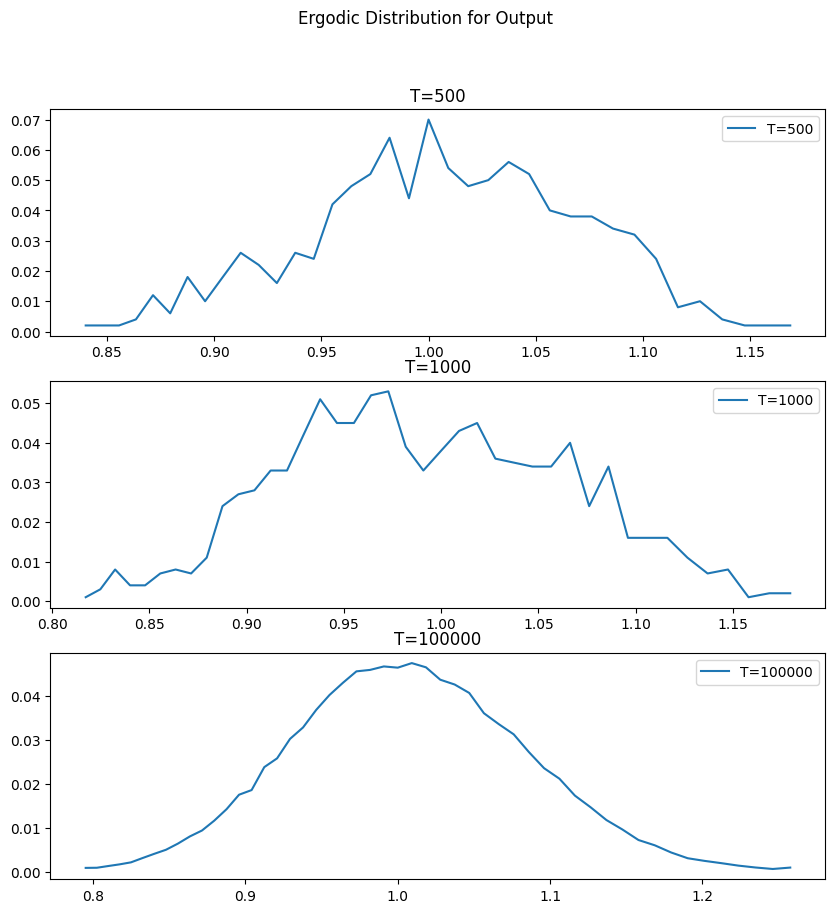

In [12]:
### Computing the ergordic distribution of endowments and assests by looking only
# at one sample path. If the process we are analysing is ergodic, we should arrive
# to the same results that if we were able to compare across different sample paths
# for the same point in time.

"""
np.unique(): Find the unique elements of an array. Returns the sorted unique elements
of an array. There are three optional outputs in addition to the unique elements:
the indices of the input array that give the unique values the indices of the unique
array that reconstruct the input array the number of times each unique value comes
up in the input array
"""
unique, counts = np.unique(y_sim, return_counts=True)
unique

# Get probabilities of ocurrence:

counts = (counts/T)

N = ["T=500", "T=1000", "T=100000"]
fig, ax = plt.subplots(3,figsize=(10,10))
fig.suptitle('Ergodic Distribution for Output')
i = 0
for T in [500, 1000, 100000]:
    y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ar_Econ, T, v_c, v_d, q, B_star)

    unique, counts = np.unique(y_sim, return_counts=True)
    unique
    # Get probabilities of ocurrence:
    counts = (counts/T)
    ax[i].plot(unique, counts, label = N[i])
    ax[i].legend()
    ax[i].set_title(N[i])
    i +=1
plt.show()

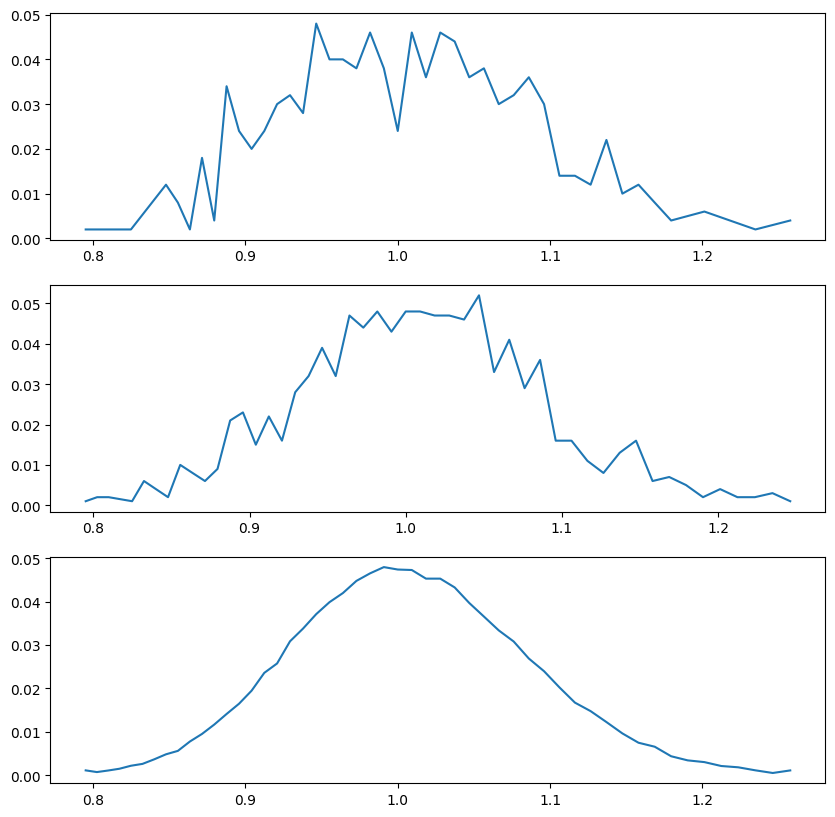

In [13]:
"""
Now instead of simulating the time series for a long period of time and the computing the the fraction of 
times the economy was at each state, we generate a large amount of samples of length T=100 (this should
not affect the result) and then repeat the analysis done before but across different samples.

"""

# Create a vector to store the last observation for each sample path, for each variable: 

T = 100
n_r = [500, 1000, 100000]
fig, ax = plt.subplots(3, figsize=(10,10))
for e in range(3):

    y_sim_r, y_a_sim_r, B_sim_r, q_sim_r, d_sim_r =  np.empty(n_r[e]), np.empty(n_r[e]), np.empty(n_r[e]), np.empty(n_r[e]), np.empty(n_r[e])

    for i in range(n_r[e]):

        y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ar_Econ, T, v_c, v_d, q, B_star)
        y_sim_r[i] = y_sim[-1]
        y_a_sim_r[i] = y_a_sim[-1]
        B_sim_r[i] = B_sim[-1]
        q_sim_r[i] = q_sim[-1]
        d_sim_r[i] = d_sim[-1]

    unique, counts = np.unique(y_sim_r, return_counts=True)
    counts = (counts/n_r[e])
    ax[e].plot(unique, counts)

plt.show()

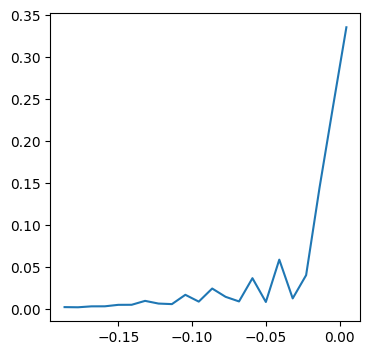

In [14]:
### Computing the marginal distribution of debt looking across samples:

T = 500
n_r = 100000
fig, ax = plt.subplots(figsize=(4,4))
y_sim_r, y_a_sim_r, B_sim_r, q_sim_r, d_sim_r =  np.empty(n_r), np.empty(n_r), np.empty(n_r), np.empty(n_r), np.empty(n_r)

for i in range(n_r):

    y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ar_Econ, T, v_c, v_d, q, B_star)
    y_sim_r[i] = y_sim[-1]
    y_a_sim_r[i] = y_a_sim[-1]
    B_sim_r[i] = B_sim[-1]
    q_sim_r[i] = q_sim[-1]
    d_sim_r[i] = d_sim[-1]

unique, counts = np.unique(B_sim_r, return_counts=True)
counts = (counts/n_r)
ax.plot(unique, counts)

plt.show()

### Ergodic Distributions ###

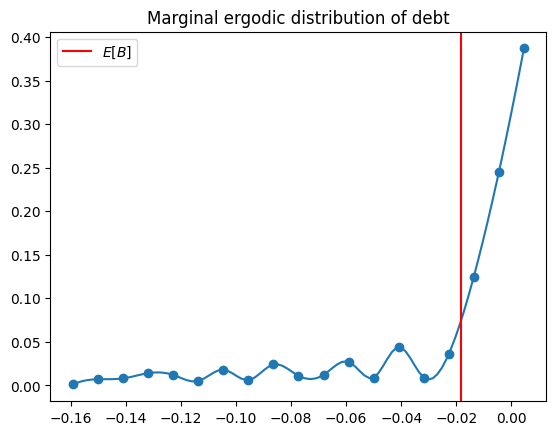

In [15]:
""" 
Now we will compute the marginal ergodic distribution of debt. For this we take T = 100.000 
and simulate the economy. Then we analyse the sample path generate and look at the distribution
od debt along with some statistics.

Remark: If we make the grid for bonds to thin, the graphs for computing the distributions of debt
seem worst. Even when we make simulations sufficiently long. Why is this? NIce plots are obtained
when B_grid_size = 51.

"""
### Computing the marginal ergodic distribution of debt.

# Pick a time horizon for the time series:

T = 1000

# Simulate the economy:

y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ar_Econ, T, v_c, v_d, q, B_star) 

# Count the values of debt and the fraction:

unique, counts = np.unique(B_sim, return_counts=True)

# Transform the total repetitions into probabilities:

counts = (counts/T)

# Plot:

fig, ax = plt.subplots()
# Use a Cubic-Spline:
ax.scatter(unique, counts)
# interpolate
dis_B = scipy.interpolate.CubicSpline(unique, counts)
#Generate grid:
grid = np.linspace(unique[0], unique[-1], Ar_Econ.B_grid_size)
# Plot
ax.plot(grid, dis_B(grid))
ax.axvline(unique @ counts, color = 'r', label = r'$E[B]$')
ax.set_title('Marginal ergodic distribution of debt')
ax.legend()
plt.show()


### The average level of debt and the amount of time in the default state ####

The average level of debt that this economy takes in the interanational markets is given by the average of debt across time for a sample path, or by the average across sample paths at a given point in time (far enough from the initial conditions). Note that by construction, whenever a country is in default, the country can not issue new debt, and for all the periods that the country is in default we assume $B=0$. Since defaults happend frequently in this economy, and leaving the default state takes some time (depending on $\theta$) we see that a value of no debt is the most likely scenario.

In [16]:
print(f'Average level of debt: ', unique @ counts)
print(f'% Of defaults as a fraction of T: ', (np.sum(d_sim)/T) *100)

Average level of debt:  -0.018427272727272757
% Of defaults as a fraction of T:  23.599999999999998


### Average output lost in default ###

If the economy chooses to default (or is still in default) at time $t$ then current output at that period automatically decreases to $h(y)$ where:

$$ h(y)=\left\{\begin{array}{ll}
\widehat{y} & \text { if } y>\widehat{y} \\
y & \text { if } y \leq \widehat{y}
\end{array}\right\} $$

In the model computed above we calibrated $\hat{y}=0.969$.

Note that in this model, re-entering the credit markets is not voluntarily. Countries get the chance to regain access to international markets randomly.

We will observe that a country is losing output, when the country is in default and the "undistorted income" is above $\hat{y}$. In this scenario, if the 
country remain in default the output loss will be equal to $(\hat{y}-y)/y$. In what follows im going to compute the average output lost, conditional on being in default. For example, if this number is -50% it means that in average the country looses 50% of its output when it was in default compared to getting the "undistorted income". Note that this number will never be positive.

In [17]:
"""
y_sim[d_sim]: "Undistorted income" for this simulation only for periods when the economy was in default.
y_sim_a[d_sim]: Observed income" for this simulation only for periods when the economy was in default.
Output_loss: For each defaulted period, what was the percentage loss with respect to the "Undistorted
             income". If 0, that means that both outputs where the same. This is something we would 
             expect if the persitance of the process is high compared to $\theta$.
a_OL: Average output loss, computed as the sum of Output_loss/(Total amount of periods).
"""
Output_loss = (y_a_sim[d_sim == 1] - y_sim[d_sim == 1 ]) / y_sim[d_sim == 1 ]
a_OL = np.sum(Output_loss)/ np.sum(d_sim)

print(f'Average % output loss in default: ', 100*a_OL)

Average % output loss in default:  -0.19795699626537583


### Modifying default costs in the original code ###

Now we are going to analyse what would happen if we change $h(y_t)$ to be:

$$ h(y) = 0.98 y_{t} $$

The difference being that now the goverment always loses output compared to the 
"Undistorted ouput" for every period that it is in default. Before, the goverment
only lost output if the "Undistorted ouput" was high enough during default times,
which was not so frequent since the output has memory of $\rho$. In the previous case
by the time that the "Undistorted ouput" turns to be high, the country has already 
regain access to the capital markets.




In [18]:
class AG06_Economy:

    def __init__(self, B_grid_size = 100, B_grid_min = -0.45, B_grid_max = 0.45, y_grid_size = 51, β = 0.953, 
                    γ = 2.0, r = 0.017, ρ = 0.945, σ = 3, η = 0.025, θ = 0.3, def_y_param = 0.98):

        ### Unload parameters:
        self.β, self.γ, self.r = β, γ, r
        self.ρ, self.η, self.θ = ρ, η, θ

        self.B_grid_max = B_grid_max
        self.B_grid_min = B_grid_min

        self.y_grid_size = y_grid_size
        self.B_grid_size = B_grid_size
        self.B_grid = np.linspace(B_grid_min, B_grid_max, B_grid_size)

        ### Output is distributed as an AR(1) in logs:
        # Probability matrix and states:
        # note that element (i,j) of P represents the transition probability
        # of going to state "j" given that we are in state "i".

        #markov = qe.markov.approximation.rouwenhorst( n = y_grid_size, ybar = 0, sigma = σ, rho = ρ)
        #self.P = markov.P   
        #self.y_grid = np.exp(markov.state_values)
        
        mc = qe.markov.tauchen(ρ, η, 0, 3, y_grid_size)
        self.y_grid, self.P = np.exp(mc.state_values), mc.P 

        """ Index at which B_grid is (close to) zero:
        numpy.searchsorted(a, v, side='left', sorter=None)
        Find indices where elements should be inserted to maintain order.
        Find the indices into a sorted array <a> such that, if the corresponding elements
        in <v> were inserted before the indices, the order of <a> would be preserved.
        
        For example: np.searchsorted([1,2,3,4,5], 3)
        >> 2        
         """

        self.B0_idx = np.searchsorted(self.B_grid, 1e-10)

        ### Output recieved while in default, with the same shape as y_grid:

        self.def_y = (def_y_param * self.y_grid)

        ### Define parameters and arrays:

    def params(self):
        return self.β, self.γ, self.r, self.ρ, self.η, self.θ

    def arrays(self):
        return self.P, self.y_grid, self.B_grid, self.def_y, self.B0_idx      

### Solving Aguiar and Gopinath (2006) ###

In [19]:
# Create an instance of the class

AG_econ = AG06_Economy()

# Solve the calibrated model:

Solution = solve(AG_econ)

v_c, v_d, q, B_star = Solution

Entering iteration 0.
Entering iteration 100.
Entering iteration 200.
Entering iteration 300.
Terminating at iteration 399.


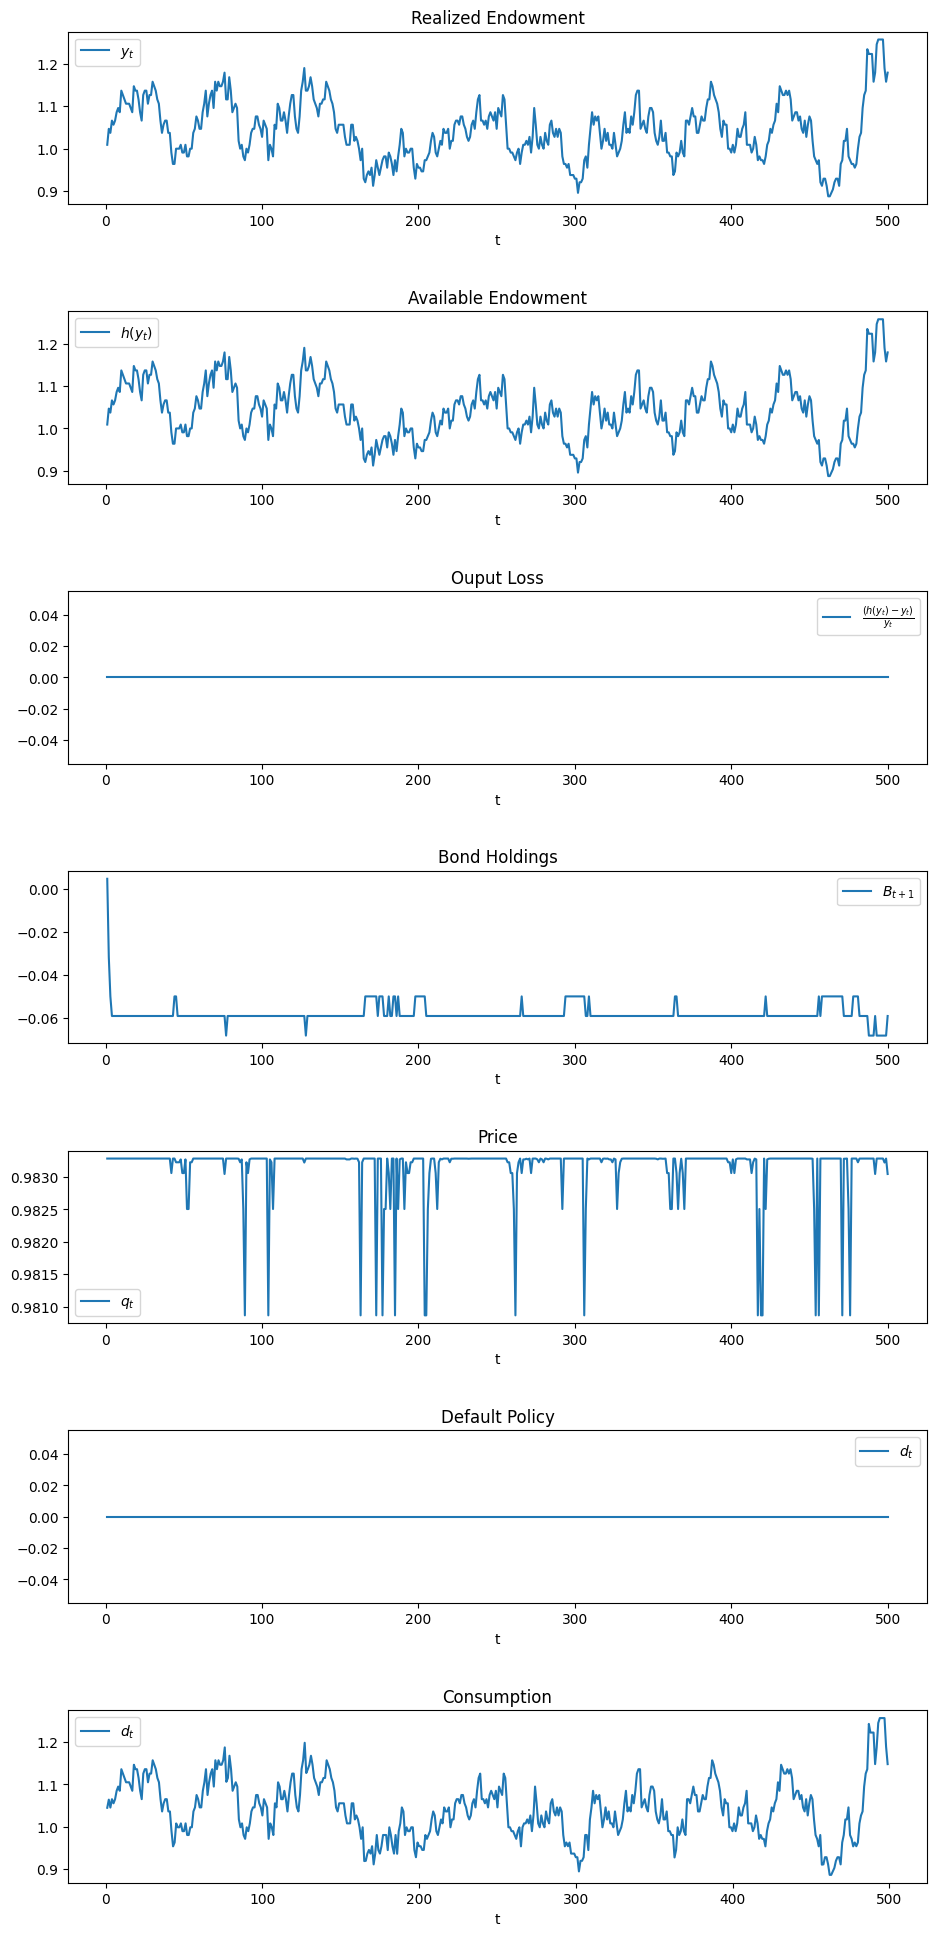

In [20]:
### Simulations:

T = 500
y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(AG_econ, T, v_c, v_d, q, B_star)

# Plots: 

fig, ax = plt.subplots(7, figsize=(10,20))

for i in range(1):
    #Simulate:
    y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(AG_econ, T, v_c, v_d, q, B_star)
    c_sim = np.empty(len(y_sim)-1)
    for i in range(len(y_sim)-1):
        c_sim[i] = y_a_sim[i] + B_sim[i] - q_sim[i] * B_sim[i+1]
    #Plot endowments time series:
    ax[0].plot(np.linspace(1, T, T), y_sim, label = r'$y_{t}$')
    ax[0].legend()
    ax[0].set_title('Realized Endowment')
    ax[0].set(xlabel='t')
    # Net income time series (In default ouput decreases):
    ax[1].plot(np.linspace(1, T, T), y_a_sim, label = r'$h(y_{t})$')
    ax[1].legend()
    ax[1].set_title('Available Endowment')
    ax[1].set(xlabel='t')
    # Output loss:
    ax[2].plot(np.linspace(1, T, T), (y_a_sim - y_sim)/ y_sim, label = r'$\frac{(h(y_{t}) - y_{t})}{y_{t}}$')
    ax[2].legend()
    ax[2].set_title('Ouput Loss')
    ax[2].set(xlabel='t')
    # Bond Holding Simulation:
    ax[3].plot(np.linspace(1, T, T), B_sim, label = r'$B_{t+1}$')
    ax[3].legend()
    ax[3].set_title('Bond Holdings')
    ax[3].set(xlabel='t')
    #Price Simulation:
    ax[4].plot(np.linspace(1, T, T), q_sim, label = r'$q_{t}$')
    ax[4].legend()
    ax[4].set_title('Price')
    ax[4].set(xlabel='t')
    # Default Simulation:
    ax[5].plot(np.linspace(1, T, T), d_sim, label = r'$d_{t}$')
    ax[5].legend()
    ax[5].set_title('Default Policy')
    ax[5].set(xlabel='t')
    # Consumption:
    ax[6].plot(np.linspace(1, T-1, T-1), c_sim, label = r'$c_{t}$')
    ax[6].legend()
    ax[6].set_title('Consumption')
    ax[6].set(xlabel='t')
    
fig.tight_layout(pad=3.0)
plt.show() 

### Ergodic Distribution ###

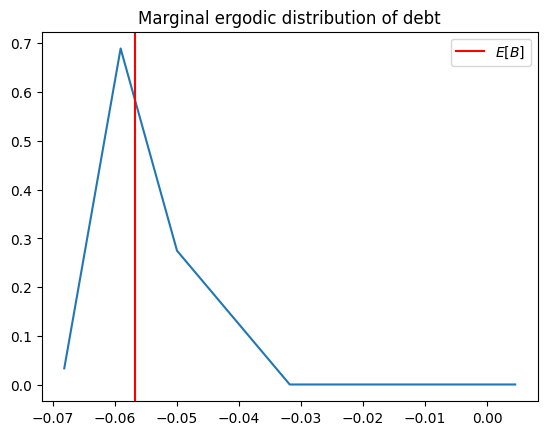

In [21]:
""" 
Now we will compute the marginal ergodic distribution of debt. For this we take T = 100.000 
and simulate the economy. Then we analyse the sample path generate and look at the distribution
od debt along with some statistics.

Remark: If we make the grid for bonds to thin, the graphs for computing the distributions of debt
seem worst. Even when we make simulations sufficiently long. Why is this? NIce plots are obtained
when B_grid_size = 51.

"""
### Computing the marginal ergodic distribution of debt.

# Pick a time horizon for the time series:

T = 1000

# Simulate the economy:

y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(AG_econ, T, v_c, v_d, q, B_star) 

# Count the values of debt and the fraction:

unique, counts = np.unique(B_sim, return_counts=True)

# Transform the total repetitions into probabilities:

counts = (counts/T)

# Plot:

fig, ax = plt.subplots()
# Use a Cubic-Spline:
ax.plot(unique, counts)
# interpolate
dis_B = scipy.interpolate.CubicSpline(unique, counts)
#Generate grid:
grid = np.linspace(unique[0], unique[-1], AG_econ.B_grid_size)
# Plot
#ax.plot(grid, dis_B(grid))
ax.axvline(unique @ counts, color = 'r', label = r'$E[B]$')
ax.set_title('Marginal ergodic distribution of debt')
ax.legend()
plt.show()


In [22]:
print(f'Average level of debt: ', unique @ counts)
print(f'Number of defaults', np.sum(d_sim))
print(f'% Of defaults as a fraction of T: ', (np.sum(d_sim)/T) *100)

Average level of debt:  -0.056809090909090955
Number of defaults 0
% Of defaults as a fraction of T:  0.0


### Discussion ### 

Only by changing $h(y_t)$ the results derived before seem to change drastically. The goverment keeps the debt almost constant. The volatility for prices is small but non zero. The probability that the goverment defaults is mostly driven by the current output as we can see in the time series.

### Increasing risk aversion ###

Let $\gamma=10$ in Arellano (2008) and compare the results with the ones found previously.

In [23]:
# Create an instance of the class with a higher risk aversion parameter:

Ar_Econ_risky = Arellano_Economy(γ = 10)

# Solve the calibrated model:

Solution = solve(Ar_Econ_risky)
v_c, v_d, q, B_star = Solution

Entering iteration 0.


C:\Users\belmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numba\core\typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "..\..\..\..\AppData\Local\Temp\ipykernel_14208\626543806.py", line 5:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


Entering iteration 100.
Entering iteration 200.
Entering iteration 300.
Terminating at iteration 361.


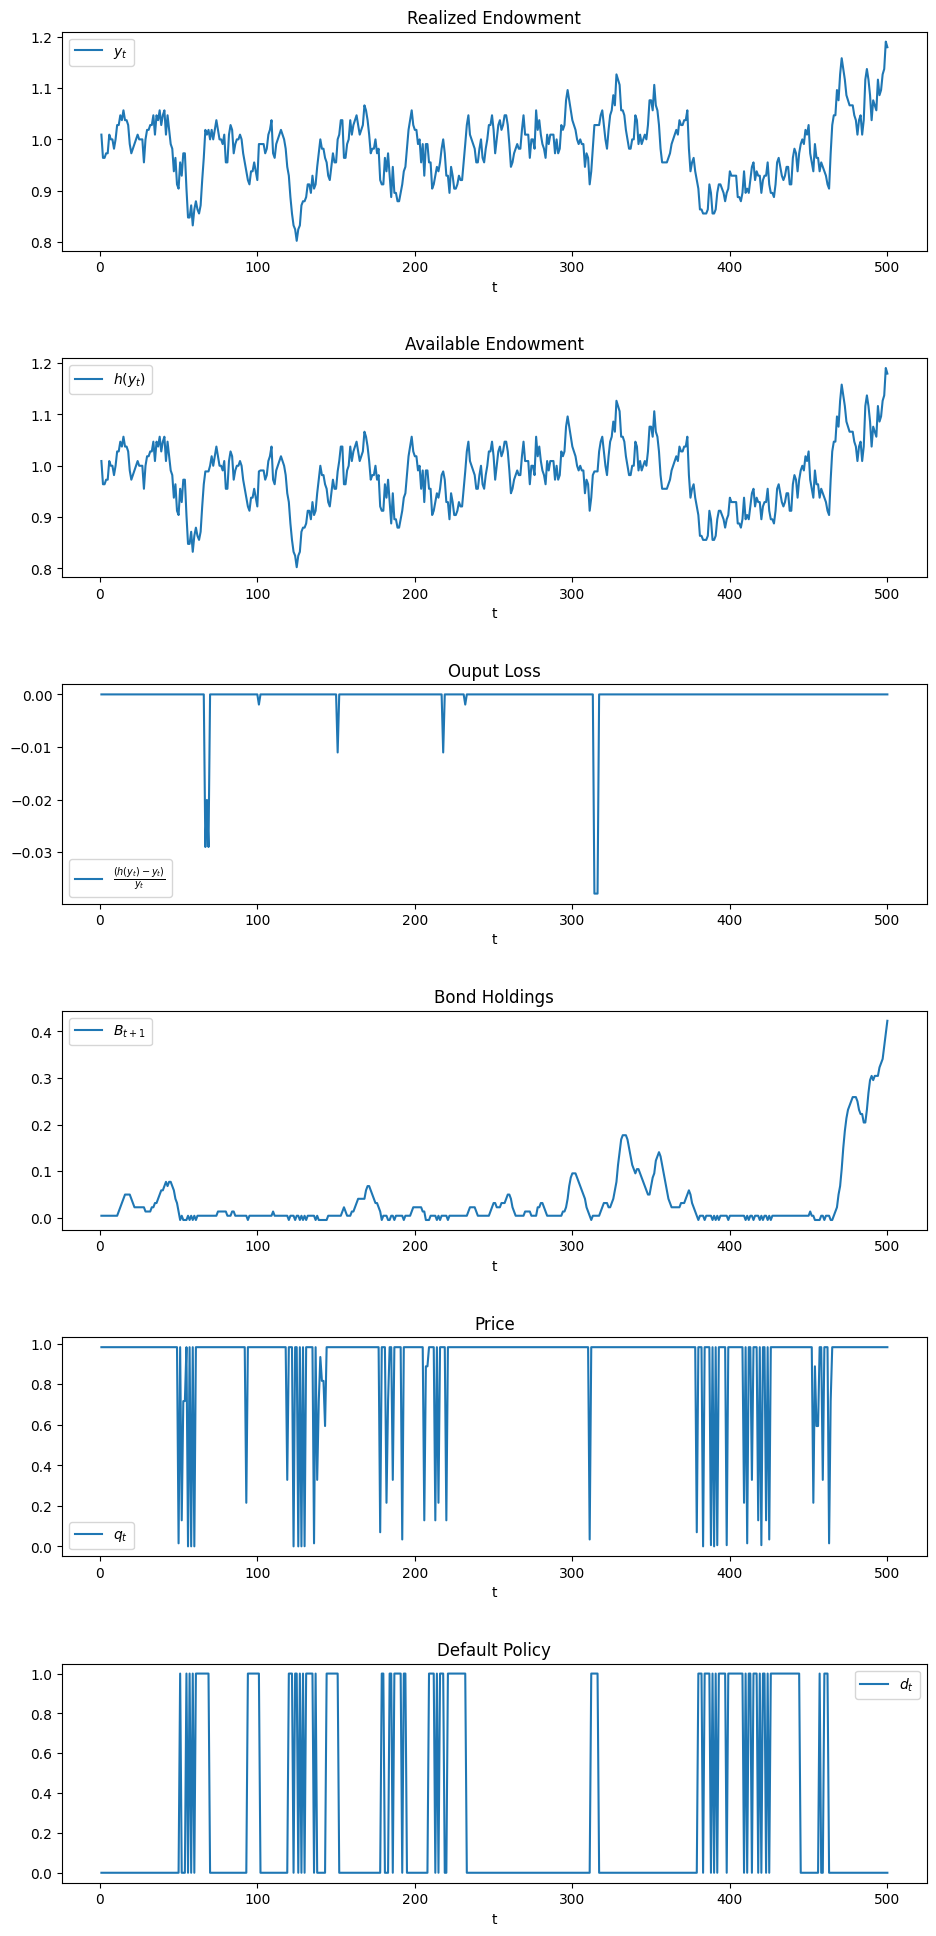

In [24]:
### Simulations:
T = 500
y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ar_Econ_risky, T, v_c, v_d, q, B_star)

T = 500
fig, ax = plt.subplots(7, figsize=(10,20))

for i in range(1):
    #Plot endowments time series:
    y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ar_Econ_risky, T, v_c, v_d, q, B_star)
    ax[0].plot(np.linspace(1, T, T), y_sim, label = r'$y_{t}$')
    ax[0].legend()
    ax[0].set_title('Realized Endowment')
    ax[0].set(xlabel='t')
    # Net income time series (In default ouput decreases):
    ax[1].plot(np.linspace(1, T, T), y_a_sim, label = r'$h(y_{t})$')
    ax[1].legend()
    ax[1].set_title('Available Endowment')
    ax[1].set(xlabel='t')
    # Output loss:
    ax[2].plot(np.linspace(1, T, T), (y_a_sim - y_sim)/ y_sim, label = r'$\frac{(h(y_{t}) - y_{t})}{y_{t}}$')
    ax[2].legend()
    ax[2].set_title('Ouput Loss')
    ax[2].set(xlabel='t')
    # Bond Holding Simulation:
    ax[3].plot(np.linspace(1, T, T), B_sim, label = r'$B_{t+1}$')
    ax[3].legend()
    ax[3].set_title('Bond Holdings')
    ax[3].set(xlabel='t')
    #Price Simulation:
    ax[4].plot(np.linspace(1, T, T), q_sim, label = r'$q_{t}$')
    ax[4].legend()
    ax[4].set_title('Price')
    ax[4].set(xlabel='t')
    # Default Simulation:
    ax[5].plot(np.linspace(1, T, T), d_sim, label = r'$d_{t}$')
    ax[5].legend()
    ax[5].set_title('Default Policy')
    ax[5].set(xlabel='t')
    # Consumption:
    ax[6].plot(np.linspace(1, T-1, T-1), c_sim, label = r'$c_{t}$')
    ax[6].legend()
    ax[6].set_title('Consumption')
    ax[6].set(xlabel='t')

fig.tight_layout(pad=3.0)
plt.show() 

### Ergodic Distributions ###

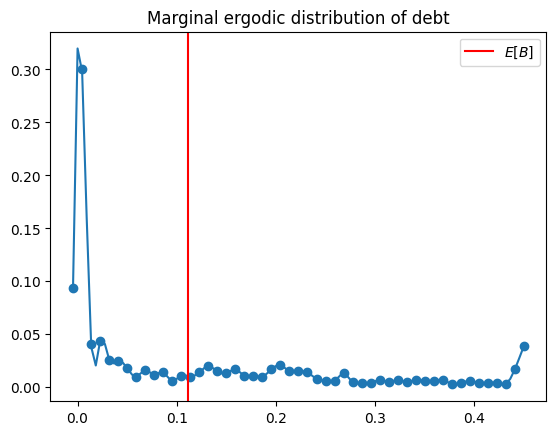

In [25]:
""" 
Now we will compute the marginal ergodic distribution of debt. For this we take T = 100.000 
and simulate the economy. Then we analyse the sample path generate and look at the distribution
od debt along with some statistics.

Remark: If we make the grid for bonds to thin, the graphs for computing the distributions of debt
seem worst. Even when we make simulations sufficiently long. Why is this? NIce plots are obtained
when B_grid_size = 51.

"""
### Computing the marginal ergodic distribution of debt.

# Pick a time horizon for the time series:

T = 1000

# Simulate the economy:

y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ar_Econ_risky, T, v_c, v_d, q, B_star) 

# Count the values of debt and the fraction:

unique, counts = np.unique(B_sim, return_counts=True)

# Transform the total repetitions into probabilities:

counts = (counts/T)

# Plot:

fig, ax = plt.subplots()
# Use a Cubic-Spline:
ax.scatter(unique, counts)
# interpolate
dis_B = scipy.interpolate.CubicSpline(unique, counts)
#Generate grid:
grid = np.linspace(unique[0], unique[-1], Ar_Econ_risky.B_grid_size)
# Plot
ax.plot(grid, dis_B(grid))
ax.axvline(unique @ counts, color = 'r', label = r'$E[B]$')
ax.set_title('Marginal ergodic distribution of debt')
ax.legend()
plt.show()


### The average level of debt and the amount of time in the default state ####

The average level of debt that this economy takes in the interanational markets is given by the average of debt across time for a sample path, or by the average across sample paths at a given point in time (far enough from the initial conditions). Note that by construction, whenever a country is in default, the country can not issue new debt, and for all the periods that the country is in default we assume $B=0$. Since defaults happend frequently in this economy, and leaving the default state takes some time (depending on $\theta$) we see that a value of no debt is the most likely scenario.

In [26]:
print(f'Average level of debt: ', unique @ counts)
print(f'% Of defaults as a fraction of T: ', (np.sum(d_sim)/T) *100)

Average level of debt:  0.11149090909090904
% Of defaults as a fraction of T:  21.6


### Analysing the different risk aversions: ###

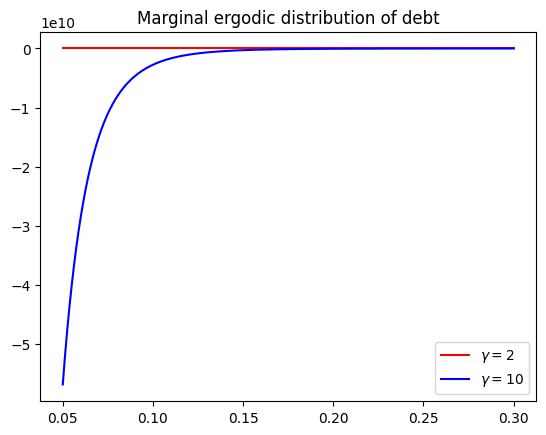

In [38]:
c_grid = np.linspace(0.05, 0.15, 200)

fig, ax = plt.subplots()
ax.plot(np.linspace(0.05, 0.3, 200), u(c_grid, γ = 2), color = 'r', label = r'$\gamma=2$')
ax.plot(np.linspace(0.05, 0.3, 200), u(c_grid, γ = 10), color = 'b', label = r'$\gamma=10$')
ax.set_title('Marginal ergodic distribution of debt')
ax.legend()
plt.show()


When $\gamma=10$ and consumption is low, the marginal utility of an extra unit of consumption is 
so big that that the government prefers to default in bad states rather than paying a small amount of debt.
In equilibrium we see default of really small amounts of debt. In fact, on average this economy saves 
across time. 

### Extension ###

Let $y^D(s)$ and $y(s)$ refer to the Arellano (08) endowment processes during default and repayment. Consider a new endowment process (in repayment): $$\hat{y}(s)=\bar{y}$$

That is, the endowment during repayment is a constant. During default, the endowment is: $$\hat{y}^D(s)= \frac{y^D(s)}{y(s)}\bar{y}$$

where: $$ y^{D}(y)=\left\{\begin{array}{ll}
{0.98} & \text { if } y>{0.98} \\
y & \text { if } y \leq {0.98}
\end{array}\right\} $$ 

That is the endowment is a constant during repayment, but during default there is an output cost of a magnitud similar to the original Arellano (08) model. Compute the ergodic distribution of debt and default states. How does it compare to Arellano (08)?

Differences:
* The goverment that repays exhibits a constant ouput.
* If the goverment defaults, there is a minimum $\bar{y}$ to output.
* When "Undistorted output" y(s) is high, and this economy is in default $\frac{y^D(s)}{y(s)}\bar{y}$ is smaller than ever.

In [74]:
class Extended_Arellano_Economy:

    def __init__(self, B_grid_size = 100, B_grid_min = -0.45, B_grid_max = 0.45, y_grid_size = 51, β = 0.953, 
                    γ = 2.0, r = 0.017, ρ = 0.945, σ = 3, η = 0.025, θ = 0.3, def_y_param = 0.98, y_bar = 1):

        ### Unload parameters:
        self.β, self.γ, self.r = β, γ, r
        self.ρ, self.η, self.θ = ρ, η, θ

        self.B_grid_max = B_grid_max
        self.B_grid_min = B_grid_min

        self.y_bar = y_bar
        self.y_grid_size = y_grid_size
        self.B_grid_size = B_grid_size
        self.B_grid = np.linspace(B_grid_min, B_grid_max, B_grid_size)

        ### Output is distributed as an AR(1) in logs:
        # Probability matrix and states:
        # note that element (i,j) of P represents the transition probability
        # of going to state "j" given that we are in state "i".

        #markov = qe.markov.approximation.rouwenhorst( n = y_grid_size, ybar = 0, sigma = σ, rho = ρ)
        #self.P = markov.P   
        #self.y_grid = np.exp(markov.state_values)
        
        mc = qe.markov.tauchen(ρ, η, 0, 3, y_grid_size)
        self.y_grid, self.P = np.exp(mc.state_values), mc.P 
    

        """ Index at which B_grid is (close to) zero:
        numpy.searchsorted(a, v, side='left', sorter=None)
        Find indices where elements should be inserted to maintain order.
        Find the indices into a sorted array <a> such that, if the corresponding elements
        in <v> were inserted before the indices, the order of <a> would be preserved.
        
        For example: np.searchsorted([1,2,3,4,5], 3)
        >> 2        
         """

        self.B0_idx = np.searchsorted(self.B_grid, 1e-10)

        ### Output recieved while in default, with the same shape as y_grid:
        # Extension for the defaulted ouput:

        self.def_y = (np.minimum(def_y_param, self.y_grid)/self.y_grid) * self.y_bar

        # Extension for output in repayment:
        # We modify the markov chain so that if the goverment rapays then 
        # the goverment obtains $y_bar$.
        
        self.y_grid_old = self.y_grid.copy()
        for i in range(len(self.y_grid)):
            self.y_grid[i] = self.y_bar 

        ### Define parameters and arrays:

    def params(self):
        return self.β, self.γ, self.r, self.ρ, self.η, self.θ

    def arrays(self):
        return self.P, self.y_grid, self.B_grid, self.def_y, self.B0_idx      

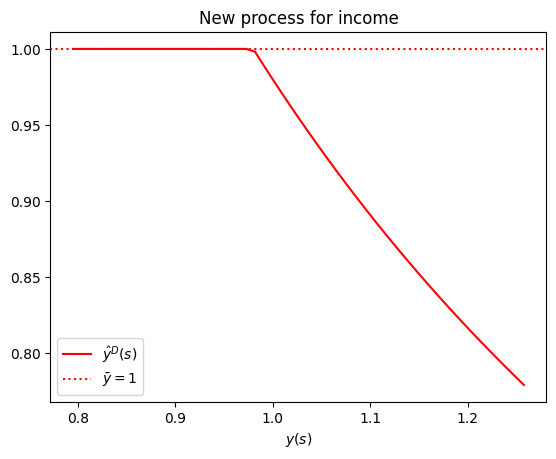

Entering iteration 0.
Entering iteration 100.
Entering iteration 200.
Entering iteration 300.
Terminating at iteration 399.


In [77]:
Ext_AR = Extended_Arellano_Economy()

### Check whether income is correct:

fig, ax = plt.subplots()
plt.plot(Ext_AR.y_grid_old, Ext_AR.def_y, color = 'r', label = r'$\hat{y}^D(s)$')
plt.axhline(Ext_AR.y_bar, color = 'r', label = r'$\bar{y}=1$', linestyle = ':')
#plt.plot(Ext_AR.y_grid_old, Ext_AR.y_grid, color = 'g', label = r'$\hat{y}^D(s)$')
#ax.plot(np.linspace(0.05, 0.3, 200), u(c_grid, γ = 10), color = 'b', label = r'$\gamma=10$')
plt.xlabel(r'$y(s)$')
plt.title('New process for income')
plt.legend()
plt.show()

Solution = solve(Ext_AR)
v_c, v_d, q, B_star = Solution


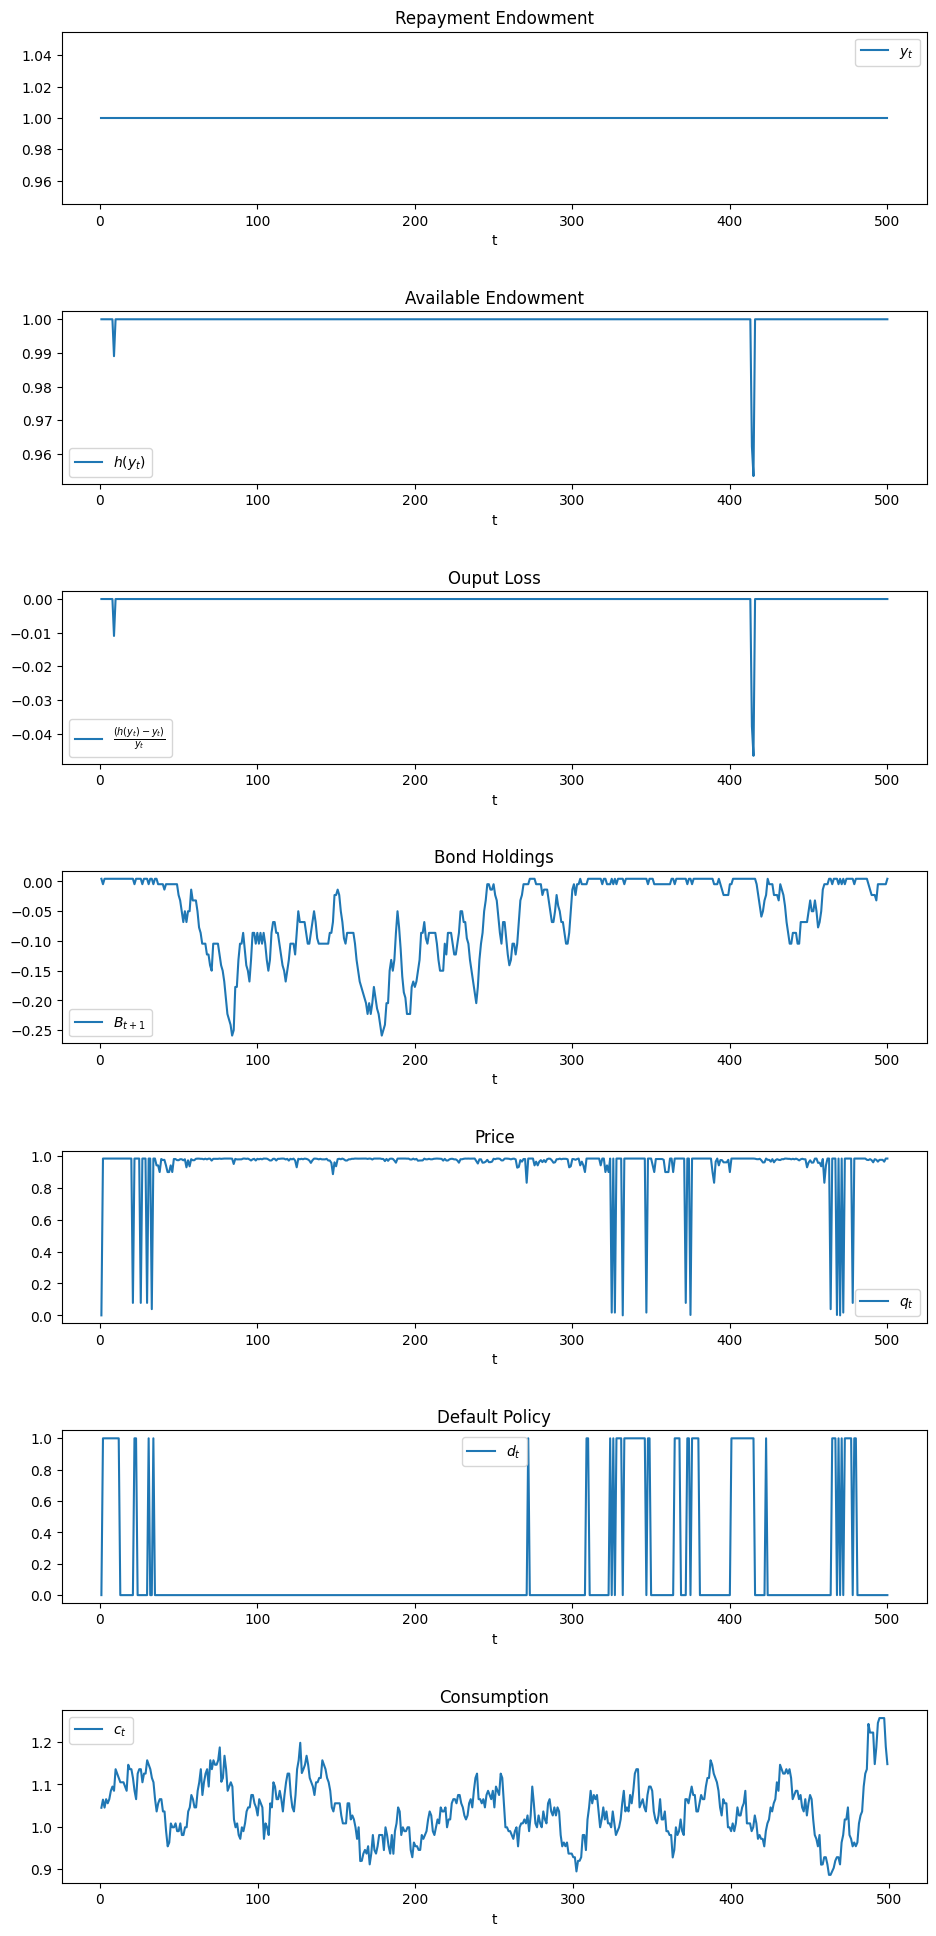

In [82]:
### Simulations:
T = 500
y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ext_AR, T, v_c, v_d, q, B_star, y_idx=int(round(Ext_AR.y_grid_size)/2))

T = 500
fig, ax = plt.subplots(7, figsize=(10,20))

for i in range(1):
    #Plot endowments time series:
    y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ext_AR, T, v_c, v_d, q, B_star, y_idx=int(round(Ext_AR.y_grid_size)/2))
    ax[0].plot(np.linspace(1, T, T), y_sim, label = r'$y_{t}$')
    ax[0].legend()
    ax[0].set_title('Repayment Endowment')
    ax[0].set(xlabel='t')
    # Net income time series (In default ouput decreases):
    ax[1].plot(np.linspace(1, T, T), y_a_sim, label = r'$h(y_{t})$')
    ax[1].legend()
    ax[1].set_title('Available Endowment')
    ax[1].set(xlabel='t')
    # Output loss:
    ax[2].plot(np.linspace(1, T, T), (y_a_sim - y_sim)/ y_sim, label = r'$\frac{(h(y_{t}) - y_{t})}{y_{t}}$')
    ax[2].legend()
    ax[2].set_title('Ouput Loss')
    ax[2].set(xlabel='t')
    # Bond Holding Simulation:
    ax[3].plot(np.linspace(1, T, T), B_sim, label = r'$B_{t+1}$')
    ax[3].legend()
    ax[3].set_title('Bond Holdings')
    ax[3].set(xlabel='t')
    #Price Simulation:
    ax[4].plot(np.linspace(1, T, T), q_sim, label = r'$q_{t}$')
    ax[4].legend()
    ax[4].set_title('Price')
    ax[4].set(xlabel='t')
    # Default Simulation:
    ax[5].plot(np.linspace(1, T, T), d_sim, label = r'$d_{t}$')
    ax[5].legend()
    ax[5].set_title('Default Policy')
    ax[5].set(xlabel='t')
    # Consumption:
    ax[6].plot(np.linspace(1, T-1, T-1), c_sim, label = r'$c_{t}$')
    ax[6].legend()
    ax[6].set_title('Consumption')
    ax[6].set(xlabel='t')

fig.tight_layout(pad=3.0)
plt.show() 

We see now that there are some defaults that are dont come associeted with an output lost, this is because output during default was so small that the repayment and default endowments coincide.

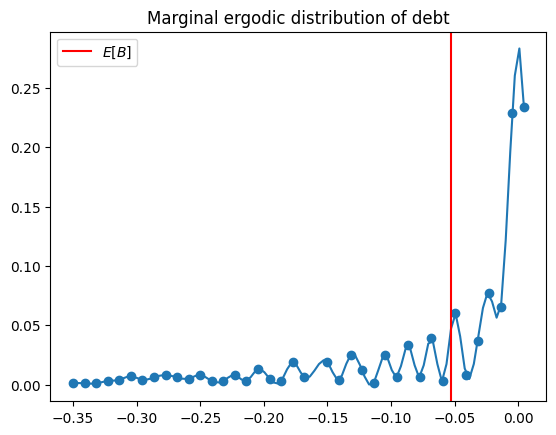

In [84]:
""" 
Now we will compute the marginal ergodic distribution of debt. For this we take T = 100.000 
and simulate the economy. Then we analyse the sample path generate and look at the distribution
od debt along with some statistics.

Remark: If we make the grid for bonds to thin, the graphs for computing the distributions of debt
seem worst. Even when we make simulations sufficiently long. Why is this? NIce plots are obtained
when B_grid_size = 51.

"""
### Computing the marginal ergodic distribution of debt.

# Pick a time horizon for the time series:

T = 1000

# Simulate the economy:

y_sim, y_a_sim, B_sim, q_sim, d_sim = simulate(Ext_AR, T, v_c, v_d, q, B_star, y_idx=int(round(Ext_AR.y_grid_size)/2))

# Count the values of debt and the fraction:

unique, counts = np.unique(B_sim, return_counts=True)

# Transform the total repetitions into probabilities:

counts = (counts/T)

# Plot:

fig, ax = plt.subplots()
# Use a Cubic-Spline:
ax.scatter(unique, counts)
# interpolate
dis_B = scipy.interpolate.CubicSpline(unique, counts)
#Generate grid:
grid = np.linspace(unique[0], unique[-1], Ext_AR.B_grid_size)
# Plot
ax.plot(grid, dis_B(grid))
ax.axvline(unique @ counts, color = 'r', label = r'$E[B]$')
ax.set_title('Marginal ergodic distribution of debt')
ax.legend()
plt.show()


In [86]:
print(f'Average level of debt: ', unique @ counts)
print(f'% Of defaults as a fraction of T: ', (np.sum(d_sim)/T) *100)
Output_loss = (y_a_sim[d_sim == 1] - y_sim[d_sim == 1 ]) / y_sim[d_sim == 1 ]
a_OL = np.sum(Output_loss)/ np.sum(d_sim)

print(f'Average % output loss in default: ', 100*a_OL)

Average level of debt:  -0.05256363636363639
% Of defaults as a fraction of T:  11.600000000000001
Average % output loss in default:  -0.21221026139096466
